In [63]:
# importing Libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from pylab import plot, show, subplot, specgram, imshow, savefig
from sklearn import preprocessing
from sklearn import cross_validation, metrics
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plote

%matplotlib inline

plt.style.use('ggplot')


In [64]:
train = pd.read_csv('../input/GDSChackathon.csv')

In [65]:
train.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [66]:
train.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


Finding types of datatypes

In [67]:
list(set(train.dtypes.tolist()))

[dtype('int64'), dtype('O'), dtype('float64')]

## function for inding missing values in dataset

In [68]:
# To check how many columns have missing values - this can be repeated to see the progress made
def show_missing():
    missing = train.columns[train.isnull().any()].tolist()
    return missing

from this we can find the total missing data in each columns

In [69]:
train[show_missing()].isnull().sum()

color                       19
director_name              104
num_critic_for_reviews      50
duration                    15
director_facebook_likes    104
actor_3_facebook_likes      23
actor_2_name                13
actor_1_facebook_likes       7
gross                      884
actor_1_name                 7
actor_3_name                23
facenumber_in_poster        13
plot_keywords              153
num_user_for_reviews        21
language                    12
country                      5
content_rating             303
budget                     492
title_year                 108
actor_2_facebook_likes      13
aspect_ratio               329
dtype: int64

## Checking is there any unespected value in score

In [70]:
train['imdb_score'].describe()

count    5043.000000
mean        6.442138
std         1.125116
min         1.600000
25%         5.800000
50%         6.600000
75%         7.200000
max         9.500000
Name: imdb_score, dtype: float64

# Finding all categorical data

In [71]:
cats = []
for col in train.columns.values:
    if train[col].dtype == 'object':
        cats.append(col)


# Creating separte datasets for Continuous vs Categorical


In [72]:
df_cont = train.drop(cats, axis=1)
df_cat = train[cats]

# Checking correlation
correlation te;

In [73]:
corr=train.corr()["imdb_score"]
corr[np.argsort(corr, axis=0)[::-1]]

imdb_score                   1.000000
num_voted_users              0.410965
num_critic_for_reviews       0.305303
num_user_for_reviews         0.292475
duration                     0.261662
movie_facebook_likes         0.247049
gross                        0.198021
director_facebook_likes      0.170802
cast_total_facebook_likes    0.085787
actor_2_facebook_likes       0.083808
actor_1_facebook_likes       0.076099
aspect_ratio                 0.059445
actor_3_facebook_likes       0.052633
budget                       0.030688
facenumber_in_poster        -0.062958
title_year                  -0.209167
Name: imdb_score, dtype: float64

# Handle Missing Data for continuous data
## If any column contains  entries of missing data, replace those missing values with the median


In [74]:
for col in df_cont.columns.values:
      if np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
         
        df_cont[col].iloc[idx] = median


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Normalization of contineous data

In [75]:
#df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]

# plotting most correlated features(correlation>0.1)

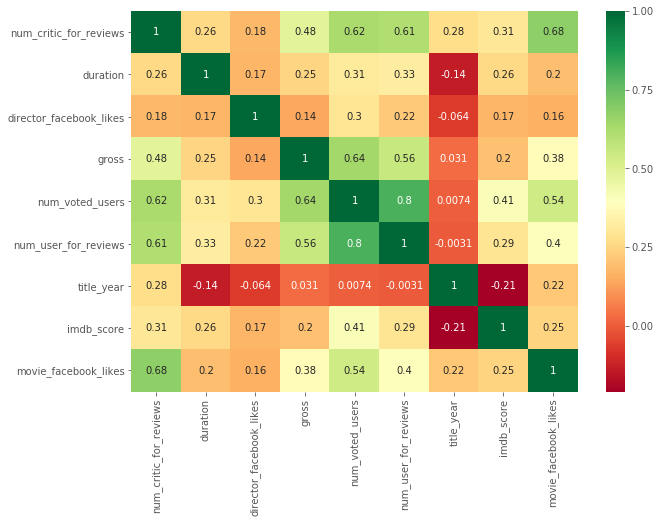

In [76]:

import seaborn as sns
corrmat = df_cont.corr()
plt.figure(figsize = (10,7))


corr_features = corrmat.index[abs(corrmat["imdb_score"])>0.1]
g = sns.heatmap(train[corr_features].corr(),annot=True,cmap="RdYlGn")


here i tried to plot the most correlated feature which are affectin the target value

# for categorical data

## Categorical Variable Genre
splitting it in multiple parts and create column genere_0 to genere_7

In [77]:
genresdf = pd.DataFrame(df_cat['genres'])
genresdf = pd.DataFrame(genresdf.genres.str.split('|').tolist(),columns = ["Genre_"+str(i) for i in  range(0,8)] )

genresdf=genresdf.reindex(df_cat.index)


df_cat.drop('genres',inplace = True, axis = 1)
df_cat = df_cat.merge(genresdf,left_index = True,right_index = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Handle Missing Data for Categorical Data

If any column contains entries of missing data, replace those values with the 'anystr'(we can replace here any string)
## Applying the sklearn.LabelEncoder


In [78]:
from sklearn.preprocessing import LabelEncoder
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('anystr')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    

# merging categorical and contineous data(both are normalised)

In [79]:
df_new = df_cont.join(df_cat)
targetfet = df_new.imdb_score

features = df_new.drop(['imdb_score'], axis = 1)

# Detailed Visualization

In [80]:
vis_dataset = pd.concat([features, targetfet], axis = 1)

## No of Movies vs imdb score

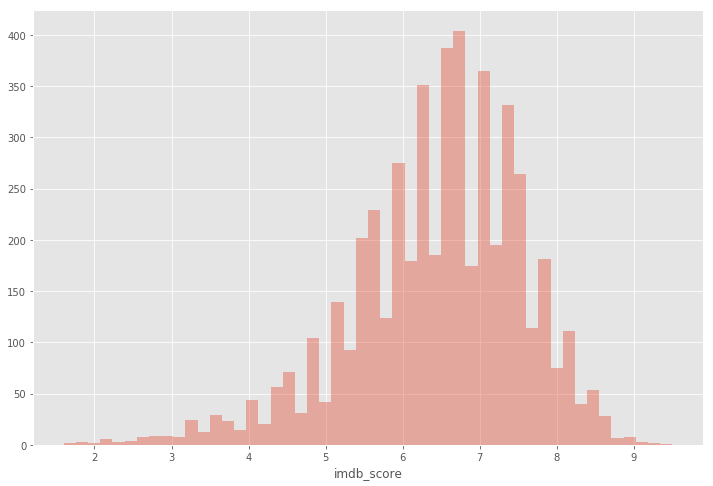

In [81]:
plt.figure(figsize=(12,8))
sns.distplot(df_cont.imdb_score.values, bins=50, kde=False)
plt.xlabel('imdb_score', fontsize=12)
plt.show()

conclusion: maximum movies are rated b/w 6 to 7.5

## Distplot
The following plot shows the distribution of imdb score (target) in the dataset.



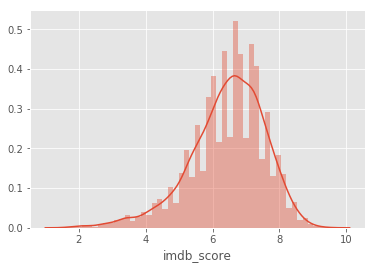

In [82]:
sns.distplot(targetfet)

## budget of movie changing by year


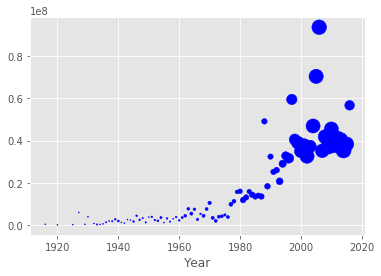

In [83]:
data_groupby_year = train.groupby(train["title_year"])
data_groupby_year_mean = data_groupby_year.mean()
Budget = plt.scatter(data_groupby_year_mean.index, data_groupby_year_mean["budget"],color = "b" ,s = data_groupby_year["budget"].count())
plt.xlabel("Year")
plt.show()

Scatter plot

## Boxoffice hit (Gross) of movie changing by year

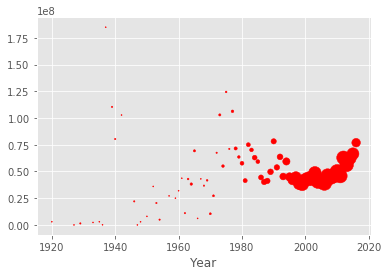

In [84]:
Gross = plt.scatter(data_groupby_year_mean.index, data_groupby_year_mean["gross"],color='r', s = data_groupby_year["gross"].count())
plt.xlabel("Year")
plt.show()

## language of movie


used BoxPlot

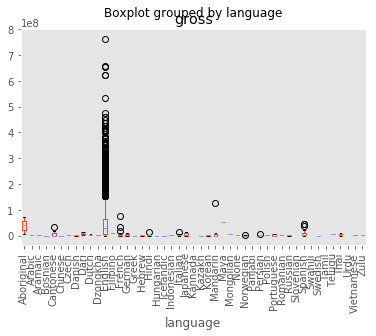

In [85]:
train.boxplot(column="gross", by="language", rot= 90, grid=False)

Gross of english movies are quit high

# splitting train and test data

In [86]:
X_train, X_test, y_train, y_test = train_test_split(features, targetfet ,test_size=0.3, random_state=7)

# plotting feature importance

In [87]:
import xgboost as xgb
xgb = xgb.XGBRegressor()
xgb.fit(X_train,y_train)
predictions_xgb = xgb.predict(X_test)
error_xgb = metrics.mean_squared_error(y_test, predictions_xgb)
print(error_xgb)

0.5509213694162202


Text(0.5,1,'feature importances')

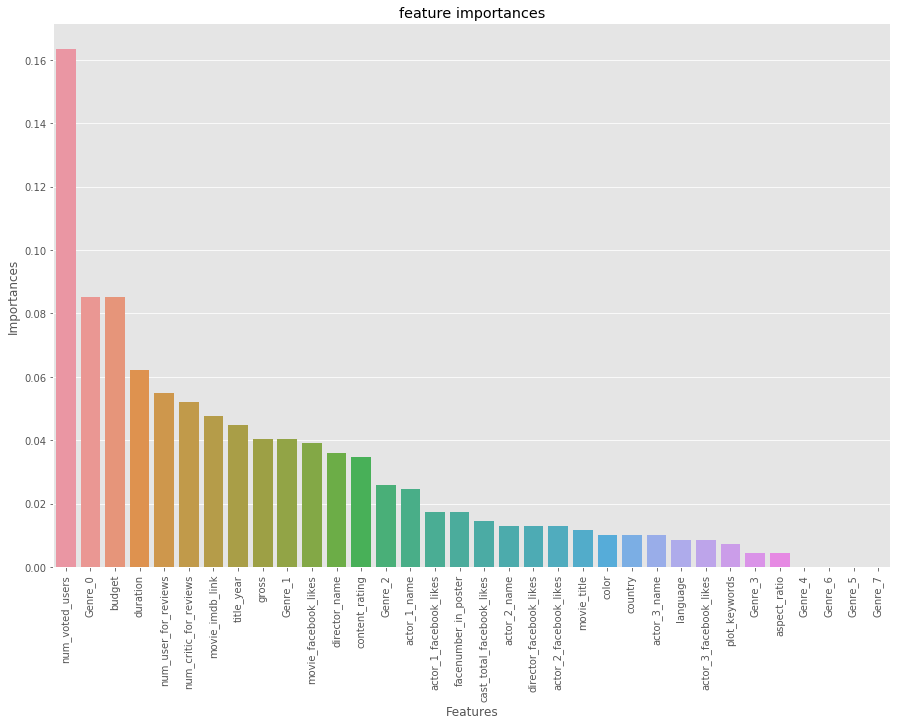

In [88]:
importances = xgb.feature_importances_
feature_names = features.columns.values
data = pd.DataFrame({'features': feature_names,'importances':importances})
new_index = (data['importances'].sort_values(ascending=False)).index.values
sorted_data = data.reindex(new_index)
plt.figure(figsize=(15,10))
ax= sns.barplot(x=sorted_data['features'], y=sorted_data['importances'])
plt.xticks(rotation= 90)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('feature importances')

voted users has the hieghest feature importance

# linear regression

In [89]:
from sklearn.linear_model import LinearRegression
clf1 = LinearRegression()
clf1.fit(X_train, y_train)
predictions_lr = clf1.predict(X_test)
error_lr = metrics.mean_squared_error(y_test, predictions_lr)
print(error_lr)

0.8359186343388991


# Linear Regression fit

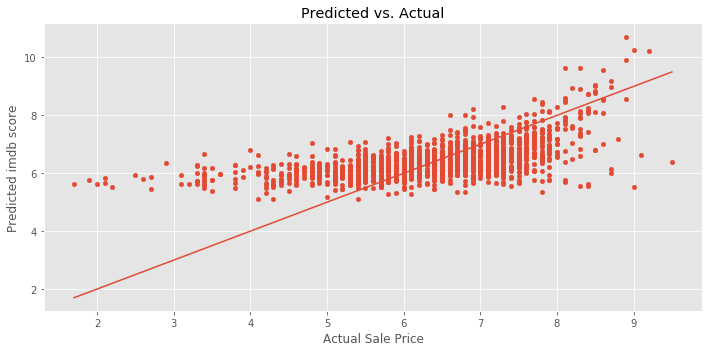

In [90]:
y_pred = clf1.predict(X_test)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted imdb score')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

here getting too much noise so trying next algorithm

# Random forest
Random Forest, the process es of finding the root node and splitting the feature so that the nodes will run randomly

In [91]:
clf = RandomForestRegressor()

clf.fit(X_train, y_train)
predictions_lr = clf.predict(X_test)
error_lr = metrics.mean_squared_error(y_test, predictions_lr)
print(error_lr)

NameError: name 'RandomForestRegressor' is not defined

# xgboost
XGBoost stands for eXtreme Gradient Boosting.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction.

In [92]:
import xgboost as xgb
xgb = xgb.XGBRegressor()
xgb.fit(X_train,y_train)
predictions_xgb = xgb.predict(X_test)
error_xgb = metrics.mean_squared_error(y_test, predictions_xgb)
print(error_xgb)

0.5509213694162202


In [93]:
y_pred

array([7.18919997, 6.41135326, 6.11607596, ..., 6.55898085, 6.24792516,
       6.40760824])

# XGBOOST graph fit


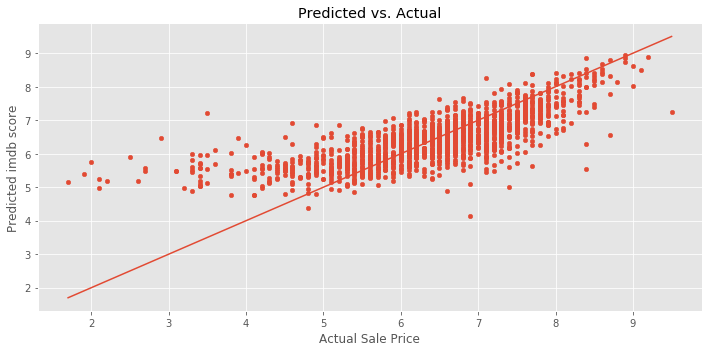

In [94]:
y_pred = xgb.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted imdb score')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()


# xgboost for finding training and testing score 

In [95]:

import xgboost as xgb
xgb = xgb.XGBRegressor()
# train the model on the training set
xgb.fit(X_train,y_train)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [96]:
xgb_score_train = xgb.score(X_test, y_test)
xgb_score_test = xgb.score(X_train, y_train)
print("Training score: ",xgb_score_train)
print("Testing score: ",xgb_score_test)

Training score:  0.5556868564775662
Testing score:  0.6517179856228006


#  random forest for finding training and testing score 

In [97]:
from sklearn.ensemble import RandomForestRegressor
dt = RandomForestRegressor(n_estimators = 1000,n_jobs=-1,random_state = 0)
dt.fit(X_train, y_train)
dt_score_train = dt.score(X_train, y_train)
print("Training score: ",dt_score_train)
dt_score_test = dt.score(X_test, y_test)
print("Testing score: ",dt_score_test)

Training score:  0.934768172534712
Testing score:  0.5333061628749185


# so here most sutable algorithm is XGBoost